In [1]:
# import self-written modules
from IndModels.models import PosModel,NGModel,GAACModel
from Ensemble.model import Ensemble

In [2]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# import modules
import numpy as np

np.random.seed(1511)

In [4]:
file = pickle.load(open('Data/TE_ML_Data_pickle.p','rb'))

In [5]:
from helper import parseEnzymeFile,modified_split

In [6]:
enzyme_filename = 'Data/Enzyme_Dataset.txt'

X,y,enz_names = parseEnzymeFile(enzyme_filename)

In [7]:
test_idx,train_idx = modified_split(enz_names)

# Position-Model

In [8]:
posModel = PosModel('Data/TE_ML_Data_pickle.p',enz_names,X,y,train_idx,test_idx,verboseQ=True,random_seed=7)

-----Initial Model Evaluation-----
-----Training Accuracy:0.9259259259259259-----
-----Testing Accuracy:0.52-----


# NG only model

In [9]:
ngModel = NGModel(enz_names,X,y,train_idx,test_idx,k=7,s=1,verboseQ=True,random_seed=7)

-----Initial Model Evaluation-----
-----Training Accuracy:0.9753086419753086-----
-----Testing Accuracy:0.52-----


# GAAC and NG model

In [10]:
gaacModel = GAACModel(enz_names,X,y,train_idx,test_idx,k=9,s=1,pca_components=40,verboseQ=True,random_seed=7)

-----Initial Model Evaluation-----
-----Training Accuracy:0.9753086419753086-----
-----Testing Accuracy:0.52-----


# Majority Vote Classifier

In [11]:
EModel = Ensemble([posModel.model,gaacModel.model,ngModel.model],
                  [posModel.Xtest,gaacModel.Xtest,ngModel.Xtest],y[test_idx])

In [12]:
EModel.acc

0.48

# Different random seeds

In [13]:
def multiprocess_func(randomseed):
    np.random.seed(randomseed)
    test_idx_i,train_idx_i = modified_split(enz_names,'Data/Enzyme-with-accession.txt')
    
    posModel_i = PosModel('Data/TE_ML_Data_pickle.p',enz_names,X,y,train_idx_i,test_idx_i)
    ngModel_i = NGModel(enz_names,X,y,train_idx_i,test_idx_i)
    gaacModel_i = GAACModel(enz_names,X,y,train_idx_i,test_idx_i,inc_count=False)
    
    EModel_i = Ensemble([posModel_i.model,gaacModel_i.model,ngModel_i.model],
                  [posModel_i.Xtest,gaacModel_i.Xtest,ngModel_i.Xtest],y[test_idx_i])
    
    return posModel_i.SVMobject.acc_test,ngModel_i.SVMobject.acc_test,gaacModel_i.SVMobject.acc_test,EModel_i.acc
    
    
    
    

In [14]:
import multiprocessing as mp
print(mp.cpu_count())
pool = mp.Pool(mp.cpu_count())

8


In [15]:
%%time
accs = list(pool.map(multiprocess_func,[i for i in range(10000)]))

CPU times: user 405 ms, sys: 279 ms, total: 684 ms
Wall time: 9min 32s


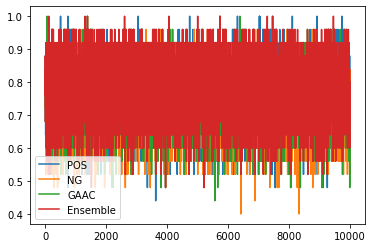

In [16]:
plt.plot(range(len(accs)),accs)
plt.legend(['POS','NG','GAAC','Ensemble'])

In [17]:
pos_preds = [a[0] for a in accs]
ng_preds = [a[1] for a in accs]
gaac_preds = [a[2] for a in accs]
ensemble_preds = [a[3] for a in accs]

In [18]:
min(pos_preds),np.mean(pos_preds),np.std(pos_preds)

(0.44, 0.7707320000000001, 0.08058501210522959)

In [19]:
min(ng_preds),np.mean(ng_preds),np.std(ng_preds)

(0.4, 0.746732, 0.0839206778809609)

In [20]:
min(gaac_preds),np.mean(gaac_preds),np.std(gaac_preds)

(0.44, 0.769392, 0.07932383208090744)

In [21]:
min(ensemble_preds),np.mean(ensemble_preds),np.std(ensemble_preds)

(0.48, 0.7837280000000001, 0.07863753566840712)

In [62]:
def save_results(filename,mylist):
    with open(f'Reports/Results/{filename}','w') as f:
        for line in mylist:
            f.write(str(line))
            f.write('\n')
    return 

def save_figure(figurename,mylist):
    plt.figure()
    values = plt.hist(mylist,bins=5);
    b=values[1]
    plt.xlabel('Accuracy bin');
    plt.ylabel('Count');
    plt.xticks(b)
    plt.title(f'{figurename} Test Accuracy Histogram');
    plt.savefig(f"Reports/Results/{'-'.join(figurename.split(' '))}.png");
    return

In [63]:
# save_results('Positional-Model.txt',pos_preds),save_results('k-mer-Model.txt',ng_preds),save_results('GAA-kmer-Model.txt',gaac_preds),save_results('Ensemble-Model.txt',ensemble_preds)

(None, None, None, None)

(None, None, None, None)

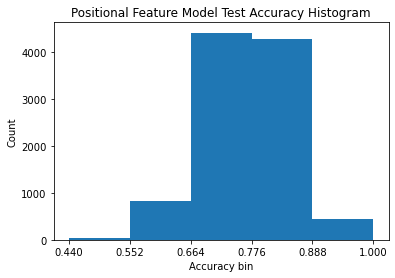

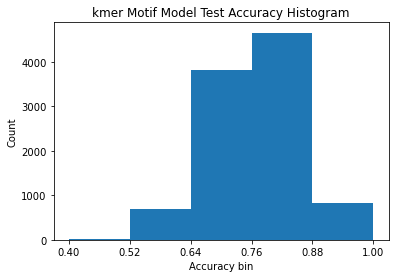

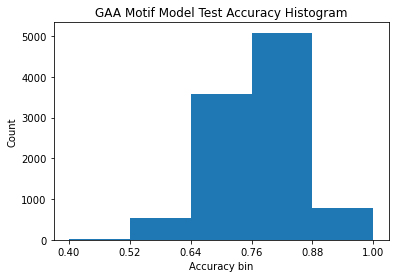

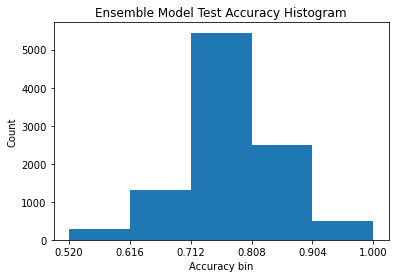

In [64]:
# save_figure('Positional Feature Model',pos_preds),save_figure('kmer Motif Model',ng_preds),save_figure('GAA Motif Model',gaac_preds),save_figure('Ensemble Model',ensemble_preds)